DICOM images loaded successfully!
Shape of image data: (91, 109, 91)


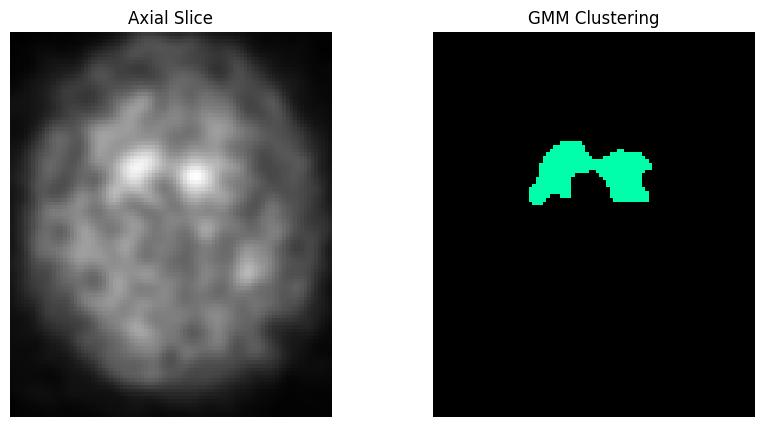

In [1]:
import os
import numpy as np
import pydicom
import cv2
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from skimage import exposure, color, morphology
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Function to load DICOM images from a directory
def load_dicom_images(dicom_dir):
    # Get list of DICOM files in the directory
    dicom_files = sorted([os.path.join(dicom_dir, file) for file in os.listdir(dicom_dir) if file.endswith('.dcm')])
    try:
        # Read DICOM files and stack pixel arrays into a 3D array
        dicom_data = [pydicom.dcmread(file) for file in dicom_files]
        preprocessed_image_data = np.stack([dicom.pixel_array for dicom in dicom_data])
        # Remove single channel dimension if present
        preprocessed_image_data = np.squeeze(preprocessed_image_data)
        return preprocessed_image_data
    except Exception as e:
        print("Error loading DICOM data:", e)
        return None

# Function to perform GMM clustering for a given slice
def gmm_clustering(slice_data):
    # Convert slice data to uint8
    slice_uint8 = (slice_data / slice_data.max() * 255).astype(np.uint8)
    # Apply histogram equalization and gamma correction
    equ = cv2.equalizeHist(slice_uint8)
    gamma_corrected = exposure.adjust_gamma(equ, gamma=1.5)
    # Apply morphological closing
    closed_data = morphology.binary_closing(gamma_corrected > 0.5, morphology.disk(3))
    # Get image dimensions
    height, width = gamma_corrected.shape
    # Create meshgrid for clustering
    y, x = np.mgrid[0:height, 0:width]
    # Reshape the image and coordinates for clustering
    reshaped_data = np.column_stack((gamma_corrected.ravel(), x.ravel(), y.ravel()))
    # Define the number of clusters
    k = 81
    # Apply Gaussian Mixture Model (GMM) clustering
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(reshaped_data)
    cluster_labels = gmm.predict(reshaped_data)
    clustered_img = cluster_labels.reshape(gamma_corrected.shape)
    # Apply hierarchical clustering to group similar clusters
    linkage_matrix = linkage(gmm.means_, 'average')
    cluster_groups = fcluster(linkage_matrix, t=100, criterion='distance')
    # Create segmented image with distinct color clusters
    segmented_img = np.zeros((height, width, 3), dtype=np.uint8)
    for i in range(k):
        cluster_pixels = gamma_corrected[clustered_img == i]
        # Set a threshold to consider only higher intensity regions
        threshold = 236
        if np.mean(cluster_pixels) > threshold:
            cluster_idx = cluster_groups[i]
            unique_color = np.array(color.hsv2rgb([cluster_idx * 360 / k, 1.0, 1.0]))
            segmented_img[clustered_img == i] = (unique_color * 255).astype(np.uint8)
    return segmented_img

# Directory containing DICOM files
dicom_dir = "B:/Sami Sir Research/Data set/pd/PPMI/140258/Reconstructed_DaTSCAN/2022-08-04_14_50_16.0/I1615951"

# Load DICOM images
image_data = load_dicom_images(dicom_dir)

if image_data is not None:
    print("DICOM images loaded successfully!")
    print("Shape of image data:", image_data.shape)

    # Select axial slice (assuming it's the middle slice)
    axial_slice_index = 42 #image_data.shape[0] // 2
    axial_slice = image_data[axial_slice_index]

    # Perform GMM clustering on axial slice
    segmented_image_gmm = gmm_clustering(axial_slice)

    # Display original axial slice and GMM clustered image
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(axial_slice, cmap='gray')
    axes[0].set_title('Axial Slice')
    axes[0].axis('off')
    axes[1].imshow(segmented_image_gmm)
    axes[1].set_title('GMM Clustering')
    axes[1].axis('off')
    plt.show()
else:
    print("Failed to load DICOM images.")


In [26]:
from skimage.segmentation import clear_border
from scipy import ndimage


def preprocess_slice(slice_data):
    try:
        # Clip data values to a specified range and normalize
        min_value = -1200
        max_value = 400
        slice_data[slice_data < min_value] = min_value
        slice_data[slice_data > max_value] = max_value
        normalized_data = (slice_data - min_value) / (max_value - min_value)

        # Apply windowing to adjust contrast and brightness
        window = 1000
        level = 250
        max_val = level + window / 2
        min_val = level - window / 2
        windowed_data = slice_data.clip(min_val, max_val)

        # Further clip data values to a narrower range
        min_val_clip = -800
        max_val_clip = 200
        clipped_data = windowed_data.clip(min_val_clip, max_val_clip)

        # Apply a morphological operation (clear_border)
        mask = clear_border(clipped_data)

        # Apply binary opening operation with 1 iteration using scipy
        opened_mask = ndimage.binary_opening(mask, iterations=3)

        # Apply binary dilation operation with 1 iteration using scipy
        dilated_mask = ndimage.binary_dilation(opened_mask, iterations=2)

        # Multiply the dilated mask with the original data
        preprocessed_slice = dilated_mask * normalized_data

        return preprocessed_slice

    except Exception as e:
        print(f"Error processing slice: {e}")
        return None
from skimage import exposure

def apply_local_histogram_equalization_to_slice(slice_data, clip_limit=0.02):
    try:
        # Apply local histogram equalization to the slice
        enhanced_slice = exposure.equalize_adapthist(slice_data, clip_limit=clip_limit)

        # Set pixels outside the region of interest to zero (black)
        enhanced_slice[slice_data == 0] = 0

        return enhanced_slice
    except Exception as e:
        print(f"Error during local histogram equalization: {e}")
        return None



def apply_gamma_correction_to_slice(slice_data, gamma=1):
    try:
        # Apply gamma correction to the slice
        gamma_corrected_slice = exposure.adjust_gamma(slice_data, gamma=gamma)
        return gamma_corrected_slice
    except Exception as e:
        print(f"Error during gamma correction: {e}")
        return None

import cv2

# Function to apply Gaussian blur to the image
def apply_gaussian_blur(image, sigma=1.0):
    try:
        # Apply Gaussian blur to the image
        blurred_image = cv2.GaussianBlur(image, (5, 5), sigma)
        return blurred_image
    except Exception as e:
        print(f"Error during Gaussian blur: {e}")
        return None

# Function to apply sharpening using unsharp masking
def apply_sharpening(image, alpha=1.0):
    try:
        # Apply Gaussian blur to the image
        blurred = cv2.GaussianBlur(image, (5, 5), 0)
        # Perform unsharp masking
        sharpened = cv2.addWeighted(image, 1 + alpha, blurred, -alpha, 0)
        return sharpened
    except Exception as e:
        print(f"Error during sharpening: {e}")
        return None


In [30]:
# Function to preprocess a single slice with all preprocessing steps
def preprocess_slice_with_all_steps(slice_data):
    # Preprocess the slice
    preprocessed_slice = preprocess_slice(slice_data)
    if preprocessed_slice is None:
        return None
    
    # Apply local histogram equalization
    enhanced_slice = apply_local_histogram_equalization_to_slice(preprocessed_slice)
    if enhanced_slice is None:
        return None
    
    # Apply gamma correction
    gamma_corrected_slice = apply_gamma_correction_to_slice(enhanced_slice)
    if gamma_corrected_slice is None:
        return None
    
    # Apply Gaussian blur
    blurred_slice = apply_gaussian_blur(gamma_corrected_slice)
    if blurred_slice is None:
        return None
    
    # Apply sharpening
    sharpened_slice = apply_sharpening(blurred_slice)
    if sharpened_slice is None:
        return None
    
    return sharpened_slice


DICOM images loaded successfully!
Shape of image data: (91, 109, 91)


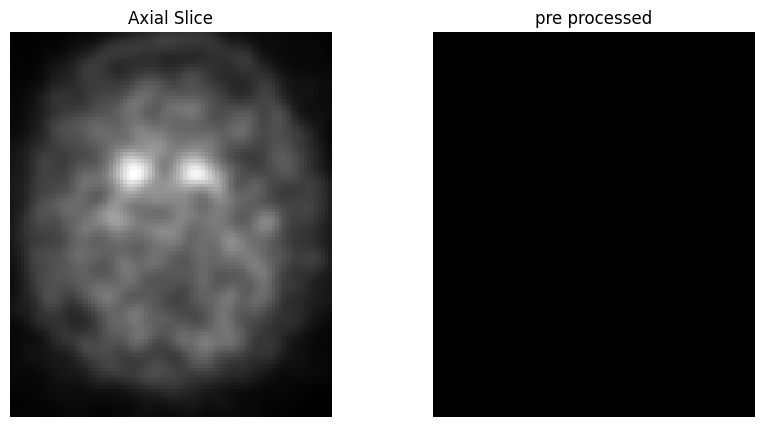

In [31]:
dicom_dir = "B:/Sami Sir Research/Data set/pd/PPMI/140258/Reconstructed_DaTSCAN/2022-08-04_14_50_16.0/I1615951"

# Load DICOM images
image_data = load_dicom_images(dicom_dir)

if image_data is not None:
    print("DICOM images loaded successfully!")
    print("Shape of image data:", image_data.shape)

    # Select axial slice (assuming it's the middle slice)
    axial_slice_index = 37 #image_data.shape[0] // 2
    axial_slice = image_data[axial_slice_index]



    # Display original axial slice and GMM clustered image
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(axial_slice, cmap='gray')
    axes[0].set_title('Axial Slice')
    axes[0].axis('off')
        # Perform GMM clustering on axial slice
    segmented_image_gmm = preprocess_slice_with_all_steps(axial_slice)
    axes[1].imshow(segmented_image_gmm, cmap='gray')
    axes[1].set_title('pre processed')
    axes[1].axis('off')
    plt.show()
else:
    print("Failed to load DICOM images.")
